In [1]:
# -*- coding: utf-8 -*-
# 比特币走势预测，使用时间序列ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA  # 使用新的 ARIMA 模型
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')

In [2]:
# 数据加载
df = pd.read_csv('./bitcoin_2012-01-01_to_2018-10-31.csv')

# 将时间作为df的索引
df.Timestamp = pd.to_datetime(df.Timestamp)
df.index = df.Timestamp

# 数据探索
print(df.head())

# 按照月，季度，年来统计
df_month = df.resample('M').mean()
df_Q = df.resample('Q-DEC').mean()
df_year = df.resample('A-DEC').mean()

            Timestamp      Open      High       Low     Close  Volume_(BTC)  \
Timestamp                                                                     
2011-12-31 2011-12-31  4.465000  4.482500  4.465000  4.482500     23.829470   
2012-01-01 2012-01-01  4.806667  4.806667  4.806667  4.806667      7.200667   
2012-01-02 2012-01-02  5.000000  5.000000  5.000000  5.000000     19.048000   
2012-01-03 2012-01-03  5.252500  5.252500  5.252500  5.252500     11.004660   
2012-01-04 2012-01-04  5.200000  5.223333  5.200000  5.223333     11.914807   

            Volume_(Currency)  Weighted_Price  
Timestamp                                      
2011-12-31         106.330084        4.471603  
2012-01-01          35.259720        4.806667  
2012-01-02          95.240000        5.000000  
2012-01-03          58.100651        5.252500  
2012-01-04          63.119577        5.208159  


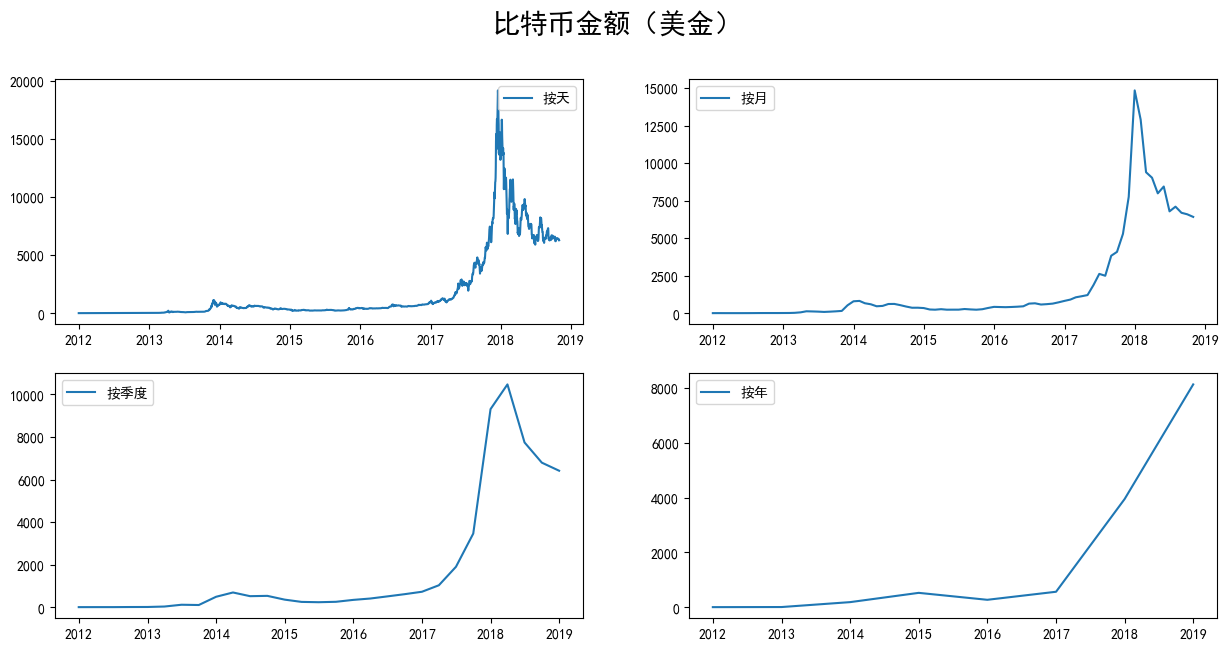

In [3]:
# 按照天，月，季度，年来显示比特币的走势
fig = plt.figure(figsize=[15, 7])
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.suptitle('比特币金额（美金）', fontsize=20)
plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='按天')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='按月')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='按季度')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='按年')
plt.legend()
plt.show()

In [4]:
# 设置参数范围
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)

# 寻找最优ARIMA模型参数，即best_aic最小
results = []
best_aic = float("inf")  # 正无穷
for param in parameters_list:
    try:
        # 使用 ARIMA 模型替代 ARMA
        model = ARIMA(df_month.Weighted_Price, order=(param[0], 0, param[1])).fit()
    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

# 输出最优模型
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print('最优模型: ', best_model.summary())

最优模型:                                 SARIMAX Results                                
Dep. Variable:         Weighted_Price   No. Observations:                   83
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -688.783
Date:                Sun, 06 Oct 2024   AIC                           1385.566
Time:                        00:05:26   BIC                           1395.242
Sample:                    12-31-2011   HQIC                          1389.453
                         - 10-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1772.9960   4642.200      0.382      0.703   -7325.548    1.09e+04
ar.L1          0.9251      0.048     19.405      0.000       0.832       1.019
ma.L1          0.2685      0.059      4.587  

In [5]:
# 比特币预测
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2018, 11, 30), datetime(2018, 12, 31), datetime(2019, 1, 31), datetime(2019, 2, 28), datetime(2019, 3, 31), 
             datetime(2019, 4, 30), datetime(2019, 5, 31), datetime(2019, 6, 30)]
future = pd.DataFrame(index=date_list, columns=df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = best_model.predict(start=0, end=91)

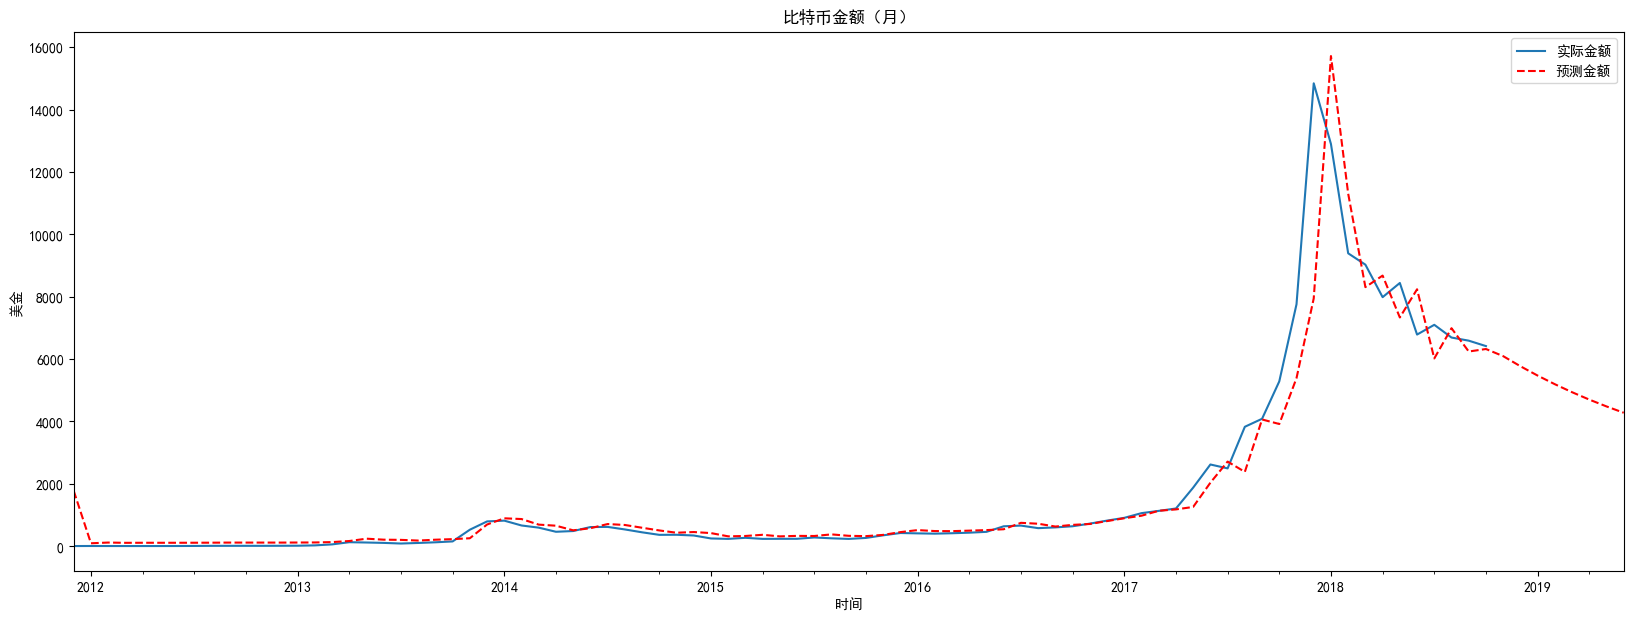

In [6]:
# 比特币预测结果显示
plt.figure(figsize=(20,7))
df_month2.Weighted_Price.plot(label='实际金额')
df_month2.forecast.plot(color='r', ls='--', label='预测金额')
plt.legend()
plt.title('比特币金额（月）')
plt.xlabel('时间')
plt.ylabel('美金')
plt.show()